In [2]:
import networkx as nx
import pandas as pd
import numpy as np

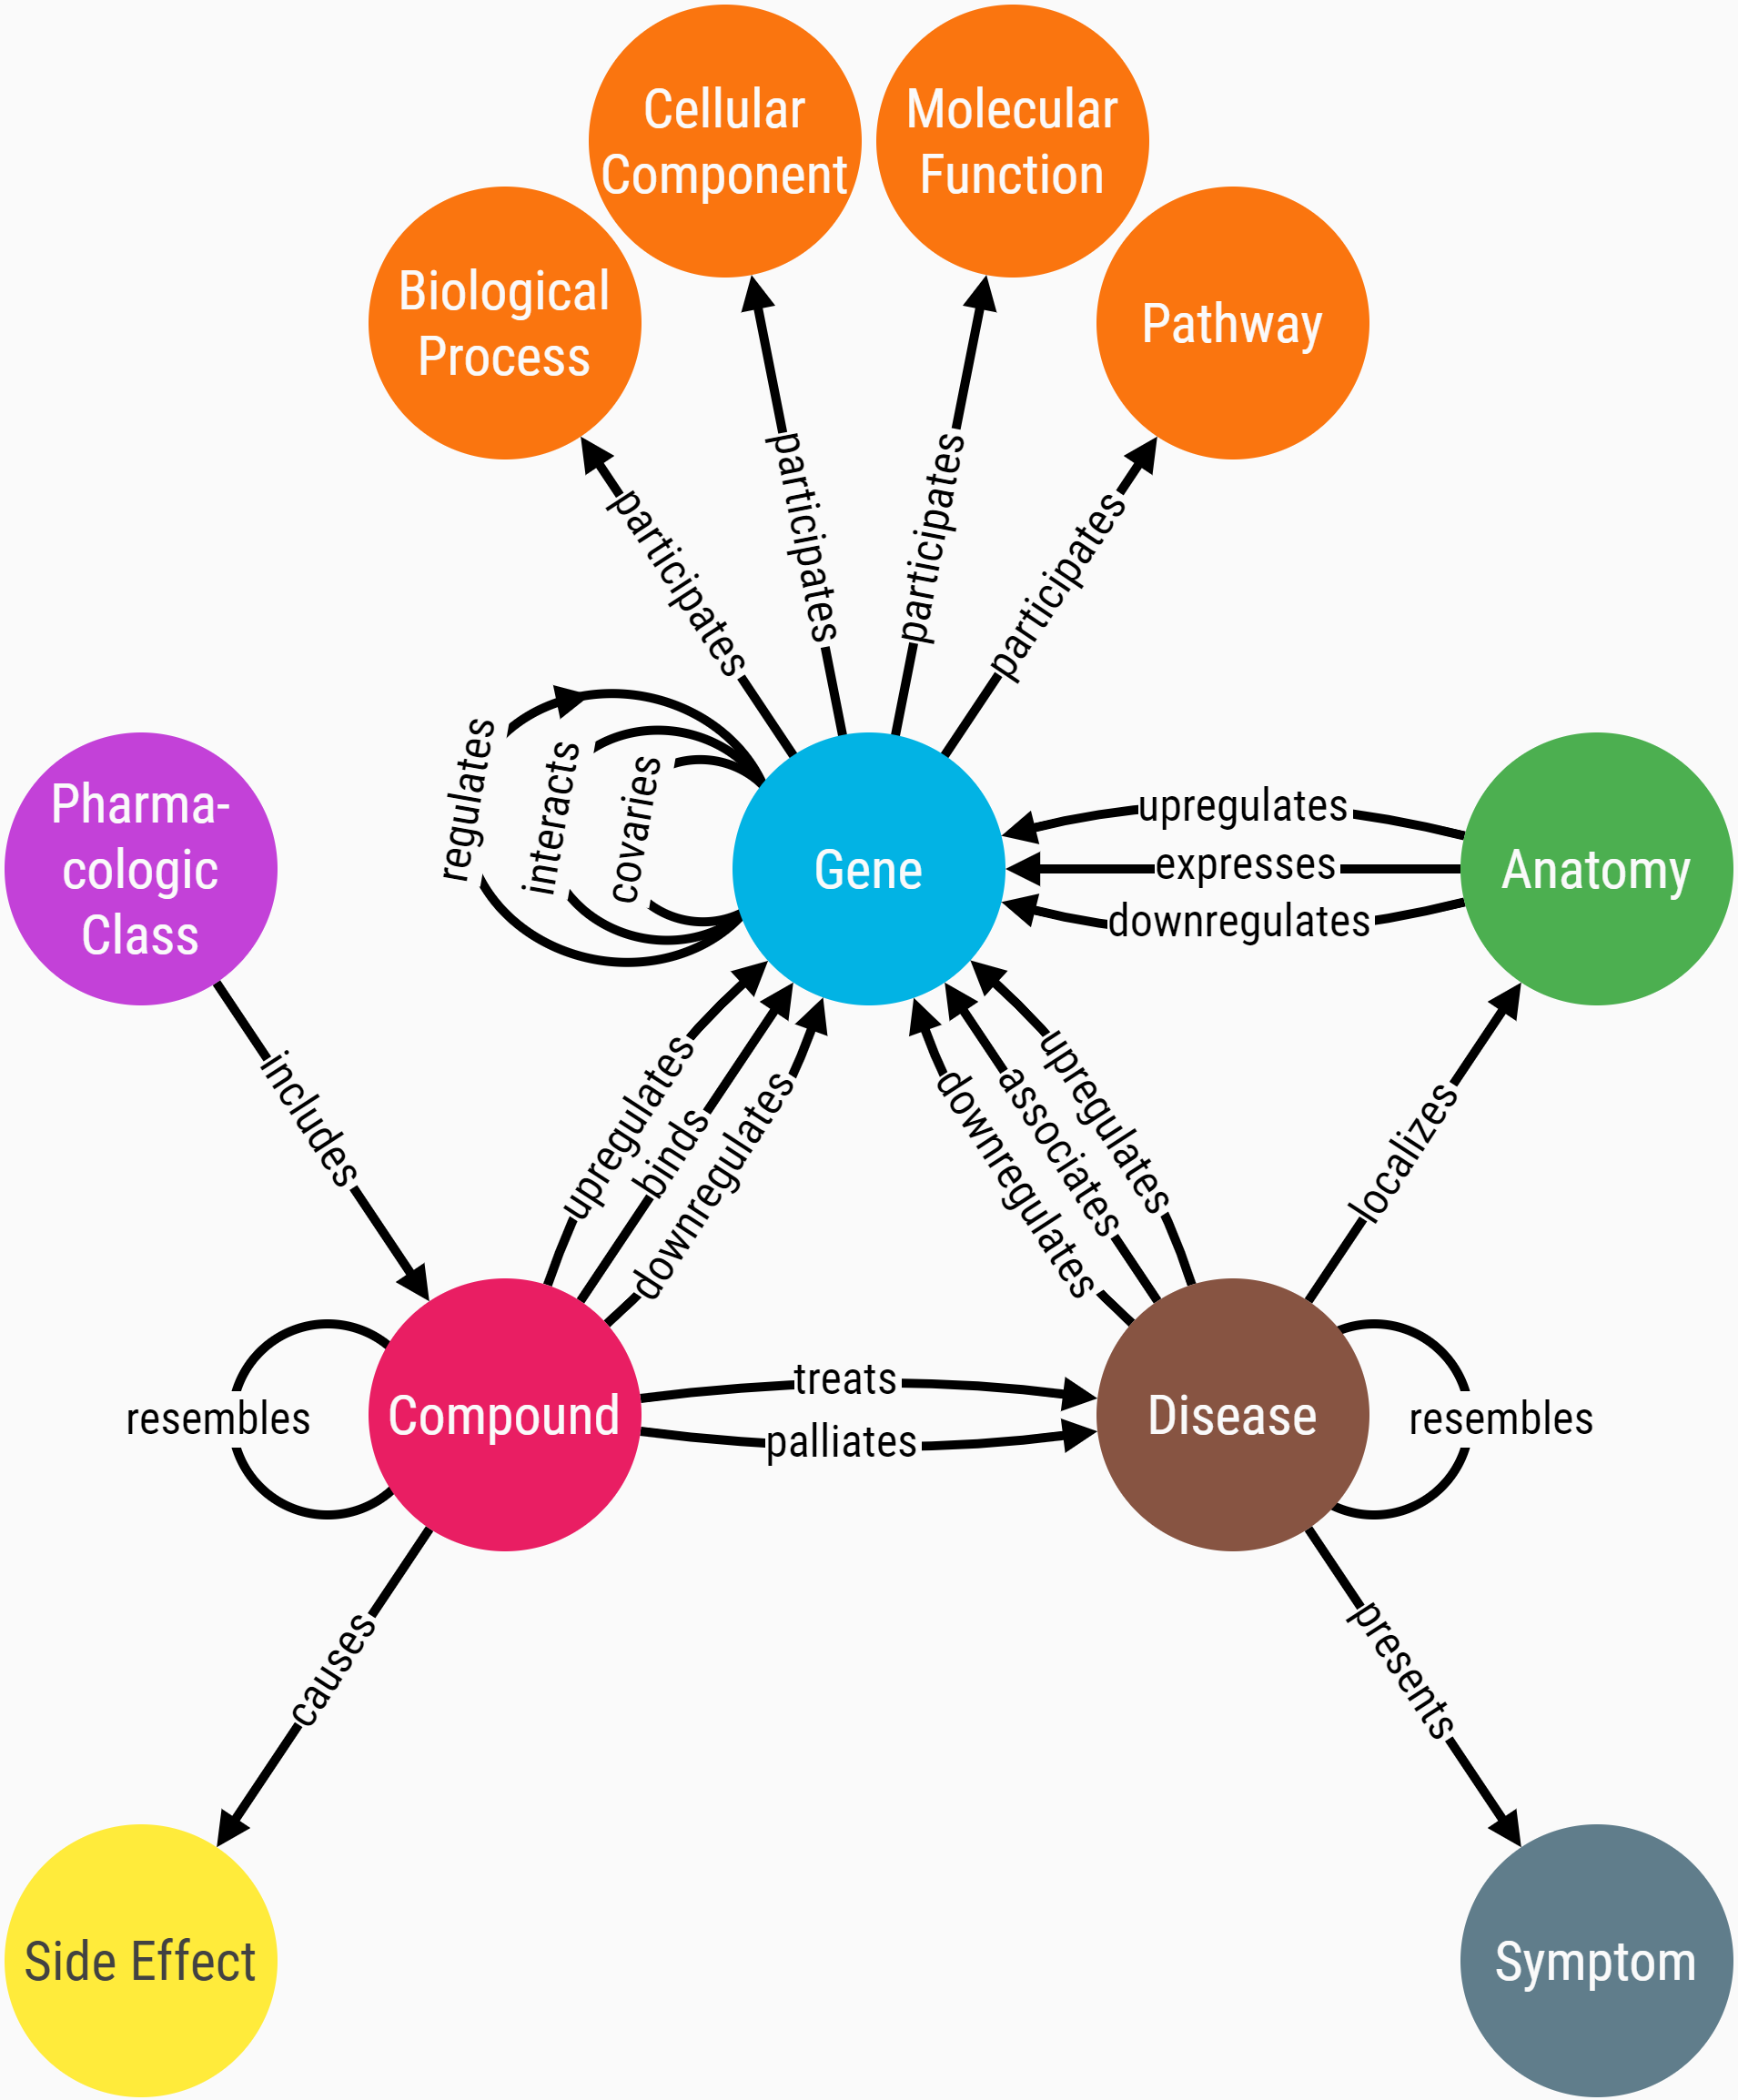

In [3]:
from IPython.display import Image
from IPython.display import display

img_path = '../data/metagraph.png'
display(Image(filename=img_path, width=400, height=300))


# Definitions


In [4]:
definitions = pd.read_json('../data/hetionet/describe/definitions.json', typ='split')
using_nodes = ["Gene","Compound","Disease"]

#metanodes -"Gene","Compound","Disease"
for node in using_nodes:
    print(f'{node} : {definitions["metanodes"].get(node)}')

Gene : Protein-coding human genes. From Entrez Gene.
Compound : Approved small molecule compounds with documented chemical structures. From DrugBank.
Disease : Complex diseases, selected to be distinct and specific enough to be clinically relevant yet general enough to be well annotated. From Disease Ontology.


In [5]:
not_using_nodes = [node for node in definitions["metanodes"].keys() if node not in using_nodes]

In [6]:
using_edges = []

for edge in definitions["metaedges"].keys():
    e = edge.split('–')
    if (e[0] not in not_using_nodes) and (e[-1] not in not_using_nodes):
        using_edges.append(edge.replace('–',' - '))
        print(f'{edge} : {definitions["metaedges"].get(edge)}','\n')

Compound–binds–Gene : The Compound physically binds to the Gene's protein product according to BindingDB, DrugBank, or DrugCentral 

Compound–downregulates–Gene : The Gene is under-expressed in samples exposed to the Compound according to a consensus signature from LINCS L1000 

Compound–palliates–Disease : The Compound is a symptomatic indication for the Disease (i.e. the Compound treats a significant symptom of the Disease) according to PharmacotherapyDB 

Compound–resembles–Compound : The Compounds are chemical similar to each other: Their extended connectivity fingerprints have a Dice coefficient ≥ 0.5. 

Compound–treats–Disease : The Compound is a disease-modifying indication for the Disease (i.e. the Compound therapeutically changes the underlying or downstream biology of the Disease) according to PharmacotherapyDB 

Compound–upregulates–Gene : The Gene is over-expressed in samples exposed to the Compound according to a consensus signature from LINCS L1000 

Disease–associates–Ge

# nodes


In [7]:
metanodes = pd.read_csv('../data/hetionet/describe/nodes/metanodes.tsv', sep='\t')
metanodes.query('metanode in @using_nodes')

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
3,Compound,C,8,1552,14
4,Disease,D,8,137,1
5,Gene,G,16,20945,1800


In [8]:
nodes = pd.read_csv('../data/hetionet-v1.0-nodes.tsv', sep='\t')

In [9]:
nodes.query('kind in @using_nodes', inplace=True)

# nodes['id'] = nodes['id'].str.split('::').str[-1]

In [10]:
nodes

#### id is the node identifier prepended with the node type plus :: as a separator. 
#### name is the node name. 
#### kind is the node type.

,id,name,kind
13174,Compound::DB00014,Goserelin,Compound
13175,Compound::DB00035,Desmopressin,Compound
13176,Compound::DB00050,Cetrorelix,Compound
13177,Compound::DB00091,Cyclosporine,Compound
13178,Compound::DB00093,Felypressin,Compound
...,...,...,...
35803,Gene::9991,PTBP3,Gene
35804,Gene::9992,KCNE2,Gene
35805,Gene::9993,DGCR2,Gene
35806,Gene::9994,CASP8AP2,Gene


In [11]:
compound = nodes[nodes['id'].str.contains('Compound')]['id'].to_list()
gene = nodes[nodes['id'].str.contains('Gene')]['id'].to_list()
disease = nodes[nodes['id'].str.contains('Disease')]['id'].to_list()

# edges

In [12]:
metaedges = pd.read_csv('../data/hetionet/describe/edges/metaedges.tsv', sep='\t')
metaedges.query('metaedge in @using_edges | metaedge == "Gene > regulates > Gene"',inplace=True)
metaedges

,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
3,Compound - binds - Gene,CbG,11571,1389,1689,0
5,Compound - downregulates - Gene,CdG,21102,734,2880,21102
6,Compound - palliates - Disease,CpD,390,221,50,0
7,Compound - resembles - Compound,CrC,6486,1042,1054,6486
8,Compound - treats - Disease,CtD,755,387,77,0
9,Compound - upregulates - Gene,CuG,18756,703,3247,18756
10,Disease - associates - Gene,DaG,12623,134,5392,1284
11,Disease - downregulates - Gene,DdG,7623,44,5745,7623
14,Disease - resembles - Disease,DrD,543,112,106,0
15,Disease - upregulates - Gene,DuG,7731,44,5630,7731


In [13]:
edge_file = '../data/edges.sif'
edges = pd.read_csv(edge_file, sep='\t',)


In [14]:
edges = pd.merge(metaedges[['metaedge','abbreviation']], edges, left_on='abbreviation', right_on='metaedge')
edges.drop('metaedge_y', axis=1, inplace=True)
edges

,metaedge_x,abbreviation,source,target
0,Compound - binds - Gene,CbG,Compound::DB00514,Gene::1136
1,Compound - binds - Gene,CbG,Compound::DB00686,Gene::2246
2,Compound - binds - Gene,CbG,Compound::DB00786,Gene::4317
3,Compound - binds - Gene,CbG,Compound::DB01209,Gene::4988
4,Compound - binds - Gene,CbG,Compound::DB01588,Gene::2560
...,...,...,...,...
562101,Gene > regulates > Gene,Gr>G,Gene::5184,Gene::8659
562102,Gene > regulates > Gene,Gr>G,Gene::22818,Gene::5613
562103,Gene > regulates > Gene,Gr>G,Gene::29888,Gene::5467
562104,Gene > regulates > Gene,Gr>G,Gene::5894,Gene::595


# label

In [15]:
connected_compound_disease = edges[(edges['source'].str.contains('Compound')) & (edges['target'].str.contains('Disease'))]
connected_compound_disease

,metaedge_x,abbreviation,source,target
32673,Compound - palliates - Disease,CpD,Compound::DB01175,Disease::DOID:3312
32674,Compound - palliates - Disease,CpD,Compound::DB00321,Disease::DOID:7148
32675,Compound - palliates - Disease,CpD,Compound::DB00176,Disease::DOID:594
32676,Compound - palliates - Disease,CpD,Compound::DB01037,Disease::DOID:10652
32677,Compound - palliates - Disease,CpD,Compound::DB00945,Disease::DOID:9074
...,...,...,...,...
40299,Compound - treats - Disease,CtD,Compound::DB00860,Disease::DOID:8893
40300,Compound - treats - Disease,CtD,Compound::DB01265,Disease::DOID:2043
40301,Compound - treats - Disease,CtD,Compound::DB01030,Disease::DOID:1324
40302,Compound - treats - Disease,CtD,Compound::DB01101,Disease::DOID:5041


In [16]:
connected_compound_disease.drop(['metaedge_x', 'abbreviation'],axis=1, inplace=True)
connected_compound_disease = connected_compound_disease.assign(label = 1)
connected_compound_disease

/var/folders/h7/80308m4j7kg6zp9y8km0_ydm0000gn/T/ipykernel_3577/2249382706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_compound_disease.drop(['metaedge_x', 'abbreviation'],axis=1, inplace=True)


,source,target,label
32673,Compound::DB01175,Disease::DOID:3312,1
32674,Compound::DB00321,Disease::DOID:7148,1
32675,Compound::DB00176,Disease::DOID:594,1
32676,Compound::DB01037,Disease::DOID:10652,1
32677,Compound::DB00945,Disease::DOID:9074,1
...,...,...,...
40299,Compound::DB00860,Disease::DOID:8893,1
40300,Compound::DB01265,Disease::DOID:2043,1
40301,Compound::DB01030,Disease::DOID:1324,1
40302,Compound::DB01101,Disease::DOID:5041,1


In [17]:
connected_compound_disease_list = list(zip(connected_compound_disease['source'],connected_compound_disease['target']))


# 그래프 생성

In [18]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(compound,group='compound')
G.add_nodes_from(gene,group='gene')
G.add_nodes_from(disease,group='disease')


In [19]:

edge = list(zip(edges['source'],edges['target']))
G.add_edges_from(edge)

# Node2Vec

In [20]:
from node2vec import Node2Vec

# Node2Vec 모델 생성 및 학습
node2vec = Node2Vec(G, dimensions=60, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)


Computing transition probabilities:   0%|          | 0/22634 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 노드 임베딩 확인
embedding = model.wv[compound[0]]
print(f'Embedding for Node:, {compound[0]}, \n {embedding}')

Embedding for Node:, Compound::DB00014, 
 [-0.5630078  -0.1581918  -0.14544822  0.30690667 -0.39766446 -0.24830903
 -0.62200487 -0.18491602 -0.11298557 -0.10561422  0.04743223  0.48099616
 -0.09791514 -0.8374198   0.19133197 -0.39383072 -0.20415455  0.38369104
 -0.7697846   0.38502693  0.39973778 -0.579879   -0.31323695 -0.34860802
  0.657299    0.4232332   0.23228295 -0.5293482  -0.6217428  -0.22618882
 -0.49742836  0.70781654 -0.5031595   0.77220917  1.1449757   0.24891843
 -0.47126034  0.5735338  -0.2912507  -0.46457666  0.6974632   0.03213175
  0.2617834   0.09106716  0.28953683 -0.41880497  0.2830225   0.07948239
  0.11523543 -0.18257621  0.82813406  0.7534469  -0.48970252  0.02385247
  0.2853879  -0.14670357  0.1522799  -0.88949937 -0.01820286 -0.66473734]


In [ ]:
embedding = model.wv[disease[0]]
print(f'Embedding for Node:, {disease[0]}, \n {embedding}')

Embedding for Node:, Disease::DOID:0050156, 
 [ 0.1719586   0.08447237 -0.559008    0.1757244   0.34513748 -0.08109661
  0.18393408  0.00933196 -0.15112354 -0.4892927  -0.18561351  0.4774142
 -0.40572944 -0.24457063 -0.24147335  0.2089923  -0.09259585  0.2579927
 -0.15871082  0.18305227 -0.04223366  0.19205208  0.0476484   0.00683217
  0.70209104 -0.4339078   0.7385596  -0.36209148 -0.66056484 -0.24061584
 -0.01169518  0.32393035 -0.26148066  0.01312907  0.19442816  0.76771057
  0.06601118  0.15085049 -0.04627848 -0.12868465 -0.39534763  0.17936619
 -0.07787412 -0.39469463  0.02110334 -0.91477287 -0.0731209  -0.08255906
  0.09837171  0.18576239  0.08171052 -0.00482203  0.17870887  0.06888571
 -0.19156824  0.5328976   0.15495779  0.10762098 -0.24963455 -0.6371675 ]


# 코사인 유사도

In [ ]:
#화학적으로 서로 유사한 약물
compound_compound = edges[(edges['source'].str.contains('Compound')) & (edges['target'].str.contains('Compound'))]

compound_cosine_similarity = []
for n in range(compound_compound.shape[0]):
    A = model.wv[compound_compound['source'].iloc[n]]
    B = model.wv[compound_compound['target'].iloc[n]]
    compound_cosine_similarity.append(np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B)))


In [ ]:
#화학적으로 서로 유사한 질병
disease_disease = edges[(edges['source'].str.contains('Disease')) & (edges['target'].str.contains('Disease'))]

disease_cosine_similarity = []
for n in range(disease_disease.shape[0]):
    A = model.wv[disease_disease['source'].iloc[n]]
    B = model.wv[disease_disease['target'].iloc[n]]
    disease_cosine_similarity.append(np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B)))


In [ ]:
# 서로 관련 있는 유전자
gene_gene = edges[(edges['source'].str.contains('Gene')) & (edges['target'].str.contains('Gene'))]

gene_cosine_similarity = []
for n in range(gene_gene.shape[0]):
    A = model.wv[gene_gene['source'].iloc[n]]
    B = model.wv[gene_gene['target'].iloc[n]]
    gene_cosine_similarity.append(np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B)))

In [ ]:
# 동일한 유전자에 관여하는 약물
compound_gene = edges[(edges['source'].str.contains('Compound')) & (edges['target'].str.contains('Gene'))]
compound_gene = compound_gene.groupby('target')['source'].unique().values
compound_gene



array([array(['Compound::DB00951', 'Compound::DB00250', 'Compound::DB01015',
              'Compound::DB01068', 'Compound::DB00316', 'Compound::DB04953'],
             dtype=object)                                                   ,
       array(['Compound::DB00552', 'Compound::DB00640', 'Compound::DB00974',
              'Compound::DB01280', 'Compound::DB00194', 'Compound::DB00277',
              'Compound::DB00975'], dtype=object)                           ,
       array(['Compound::DB01103'], dtype=object), ...,
       array(['Compound::DB01103', 'Compound::DB00091', 'Compound::DB06287',
              'Compound::DB06803', 'Compound::DB01092', 'Compound::DB09020',
              'Compound::DB01590', 'Compound::DB00763', 'Compound::DB00857',
              'Compound::DB00939', 'Compound::DB01034', 'Compound::DB00602',
              'Compound::DB08916', 'Compound::DB00928', 'Compound::DB00444',
              'Compound::DB01396', 'Compound::DB00317', 'Compound::DB00374',
              'C

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


# 예제 데이터 생성
data = np.random.rand(10, 5)

# 코사인 유사도 계산
cosine_similarity_matrix = cosine_similarity(data)

cosine_similarity_matrix

array([[1.        , 0.81367842, 0.78775347, 0.63780376, 0.78076781,
        0.94594035, 0.6876589 , 0.66650758, 0.86575724, 0.71628994],
       [0.81367842, 1.        , 0.72811498, 0.8931539 , 0.85723134,
        0.89646044, 0.72141516, 0.84781209, 0.85462497, 0.65801229],
       [0.78775347, 0.72811498, 1.        , 0.82946085, 0.74430943,
        0.67995652, 0.7594261 , 0.6623308 , 0.85066785, 0.7624086 ],
       [0.63780376, 0.8931539 , 0.82946085, 1.        , 0.86485759,
        0.67857696, 0.81112186, 0.87826372, 0.86436438, 0.72661571],
       [0.78076781, 0.85723134, 0.74430943, 0.86485759, 1.        ,
        0.83426528, 0.9588888 , 0.86827114, 0.93579869, 0.91865958],
       [0.94594035, 0.89646044, 0.67995652, 0.67857696, 0.83426528,
        1.        , 0.72605347, 0.67725983, 0.81976137, 0.73294201],
       [0.6876589 , 0.72141516, 0.7594261 , 0.81112186, 0.9588888 ,
        0.72605347, 1.        , 0.73412949, 0.86044197, 0.98466608],
       [0.66650758, 0.84781209, 0.6623308

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

for i in compound_gene:
    compound_e = []
    for n in i:
        compound_e.append(model.wv[n])
    cosine_similarity_matrix = cosine_similarity(compound_e)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 코사인 유사도 히트맵
    sns.heatmap(cosine_similarity_matrix, cmap="YlGnBu", xticklabels=False, yticklabels=False, ax=axes[0])
    axes[0].set_title('Cosine Similarity')


/var/folders/h7/80308m4j7kg6zp9y8km0_ydm0000gn/T/ipykernel_17482/3179408596.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# 데이터

In [ ]:
#cartesian product
df1 = pd.DataFrame({'source':compound})
df2 = pd.DataFrame({'target':disease})

compound_disease = pd.merge(df1.assign(key=1),df2.assign(key=1), on='key').drop('key', axis=1)

#label
compound_disease = pd.merge(compound_disease, connected_compound_disease, how='outer')
compound_disease = compound_disease.fillna(0)
compound_disease

,source,target,label
0,Compound::DB00014,Disease::DOID:0050156,0.0
1,Compound::DB00014,Disease::DOID:0050425,0.0
2,Compound::DB00014,Disease::DOID:0050741,0.0
3,Compound::DB00014,Disease::DOID:0050742,0.0
4,Compound::DB00014,Disease::DOID:0060073,0.0
...,...,...,...
212619,Compound::DB09028,Disease::DOID:9744,0.0
212620,Compound::DB09028,Disease::DOID:9835,0.0
212621,Compound::DB09028,Disease::DOID:986,0.0
212622,Compound::DB09028,Disease::DOID:9917,0.0


In [ ]:
compound_disease['label'].value_counts()

0.0    211479
1.0      1145
Name: label, dtype: int64

In [ ]:
compound_disease_label = []
for com in compound:
    for dis in disease:
        val = []
        val.append(com)
        val.append(dis)
        tup = (com,dis)
        if tup in connected_compound_disease_list:
            val.append(1)
        else:
            val.append(0)
        compound_disease_label.append(val)

In [ ]:
input = []
for data in compound_disease_label:
    input.append(np.vstack([model.wv[data[0]], model.wv[data[1]]]).reshape(120,))


# Classification - LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(input, compound_disease['label'], test_size=0.3, random_state=42, stratify=compound_disease['label'])

X_subtrain, X_val, y_subtrain, y_val =\
    train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
#class_weight='balanced'

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_subtrain,y_subtrain)	


/Applications/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [ ]:
lr.score(X_subtrain,y_subtrain)


0.791438306857993

In [ ]:
lr.score(X_val,y_val)


0.7869252648316947

In [ ]:
lr.score(X_test,y_test)
															    

0.7896156016805669

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report

y_pred = lr.predict(X_val)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_val, y_pred))

Precision: 0.019433533181724208
Recall: 0.8703703703703703
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88     44435
         1.0       0.02      0.87      0.04       216

    accuracy                           0.79     44651
   macro avg       0.51      0.83      0.46     44651
weighted avg       0.99      0.79      0.88     44651



In [ ]:


y_pred = lr.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_test, y_pred))


Precision: 0.020674486803519063
Recall: 0.8197674418604651
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88     63444
         1.0       0.02      0.82      0.04       344

    accuracy                           0.79     63788
   macro avg       0.51      0.80      0.46     63788
weighted avg       0.99      0.79      0.88     63788



In [ ]:
y_test.value_counts()

0.0    63444
1.0      344
Name: label, dtype: int64

In [ ]:
np.unique(lr.predict(X_test), return_counts=True)

(array([0., 1.]), array([50148, 13640]))

In [ ]:
y_proba = lr.predict_proba(X_test)[:, 1]

# 임계값을 조정
threshold = 0.9  # 임계값 설정
y_pred_adjusted = (y_proba > threshold).astype(int)

# 조정된 예측
print(classification_report(y_test, y_pred_adjusted))

Classification Report (Adjusted):
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     63444
         1.0       0.04      0.24      0.07       344

    accuracy                           0.96     63788
   macro avg       0.52      0.60      0.52     63788
weighted avg       0.99      0.96      0.98     63788



# Classification - svm

In [ ]:
from sklearn.svm import SVC

svm = SVC(class_weight='balanced', kernel='rbf', probability=True)  # kernel SVM
svm.fit(X_subtrain, y_subtrain)


SVC(class_weight='balanced', probability=True)

In [ ]:
svm.score(X_subtrain, y_subtrain)

0.9894898497864376

In [ ]:
svm.score(X_test, y_test)

0.9869567943813884

In [ ]:
y_pred = svm.predict(X_val)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_val, y_pred))

Precision: 0.23605150214592274
Recall: 0.7638888888888888
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     44435
         1.0       0.24      0.76      0.36       216

    accuracy                           0.99     44651
   macro avg       0.62      0.88      0.68     44651
weighted avg       1.00      0.99      0.99     44651



In [ ]:
y_pred = svm.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_test, y_pred))

Precision: 0.2564870259481038
Recall: 0.747093023255814
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     63444
         1.0       0.26      0.75      0.38       344

    accuracy                           0.99     63788
   macro avg       0.63      0.87      0.69     63788
weighted avg       0.99      0.99      0.99     63788



In [ ]:
y_test.value_counts()

0.0    63444
1.0      344
Name: label, dtype: int64

In [ ]:
np.unique(svm.predict(X_test), return_counts=True)

(array([0., 1.]), array([62786,  1002]))

In [ ]:
y_proba = svm.predict_proba(X_test)[:, 1]

# 임계값을 조정
threshold = 0.3  # 임계값 설정
y_pred_adjusted = (y_proba > threshold).astype(int)

# 조정된 예측
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     63444
         1.0       0.51      0.51      0.51       344

    accuracy                           0.99     63788
   macro avg       0.75      0.75      0.75     63788
weighted avg       0.99      0.99      0.99     63788



In [ ]:
np.unique(y_pred_adjusted, return_counts=True)

(array([0, 1]), array([63444,   344]))

# Evaluation

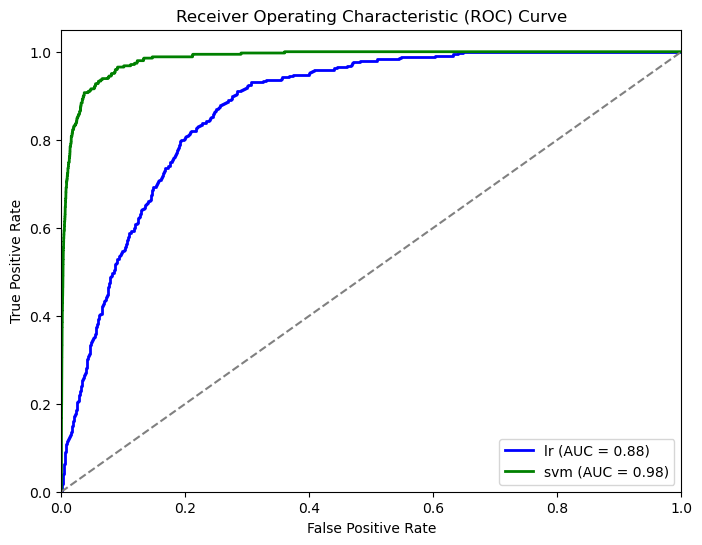

In [ ]:
import sklearn.metrics as sm
import matplotlib.pyplot as plt

# ROC curve
plt.figure(figsize=(8, 6))

# lr
y_probs = lr.predict_proba(X_test)[:, 1] #label 1에 대한 예측 확률
auc = sm.roc_auc_score(y_test, y_probs)
fpr, tpr, thresholds = sm.roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'lr (AUC = {auc:.2f})')

# svm
y_probs = svm.predict_proba(X_test)[:, 1]
auc = sm.roc_auc_score(y_test, y_probs)
fpr, tpr, thresholds = sm.roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, color='green', lw=2, label=f'svm (AUC = {auc:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()